In [1]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out[:, -1, :])  # Assuming many-to-one
        return out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.num_layers, batch_size, self.hidden_size).zero_(),
                  weight.new(self.num_layers, batch_size, self.hidden_size).zero_())
        return hidden

# import keras
# from keras import optimizers
# from keras.callbacks import History
# from keras.models import Model
# from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate,LeakyReLU

# def volatility_activation(x):
#     return K.exp(-K.square(x))


In [2]:
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
dfs = []
labels = []
pdf = pd.DataFrame()
for company in ['AAPL', 'AMD', 'AMZN', 'ASML','CSCO', 'GOOGL', 'INTC', 'MSFT', 'NVDA']:
    df_numerical = pd.read_csv('../dataset_transcript/EPS/'+company+'_EPS.csv')
    df_textural = pd.read_csv('../dataset_transcript/Transcripts/'+company+'_sentiment.csv')
    df_result = pd.read_csv('../dataset_transcript/Stock Values and Sector Index/'+company+'.csv')
    df_numerical['Date'] = pd.to_datetime(df_numerical['Date'])
    df_textural['Date'] = pd.to_datetime(df_textural['Date'])
    df_result['Date'] = pd.to_datetime(df_result['Date'])

    df_combined = pd.merge(df_textural, df_numerical, how="left", on=["Date"])

    mask = df_result['Date'].isin(df_combined['Date'])
    indices_of_interest = df_result.index[mask]
    
    previous_indices = indices_of_interest - 1
    previous_indices = previous_indices[previous_indices >= 0]
    df_previous = df_result.iloc[previous_indices].copy().reset_index(drop=True)
    df_previous = df_previous.rename(columns={col: 'prev_' + col for col in df_previous.columns})
    df_previous['Date'] = df_result.iloc[indices_of_interest].reset_index(drop=True)['Date']
    
    df_combined = pd.merge(df_combined, df_previous, how="left", on=["Date"])
    df_combined.fillna(0, inplace = True) 

    df_result = pd.merge(df_result, df_combined['Date'], how='right', on=["Date"])
    df_combined=df_combined.drop(columns=['Fiscal Quarter End', 'Date', 'prev_Date'])
    pdf=df_combined
    dfs.append(df_combined)
    labels.append(df_result['Close'])


In [3]:

# indicators = 4
# lstm_input = Input(shape=(backcandles, indicators), name='lstm_input')
# inputs = LSTM(150, name='first_layer')(lstm_input)
# inputs = Dense(1, name='dense_layer')(inputs)
# output = Activation(activation="linear", name='output')(inputs)
# model = Model(inputs=lstm_input, outputs=output)
# optimizer = "Adam"
# model.compile(optimizer=optimizer, loss='mse')
# model.fit(x=X_train, y=y_train, batch_size=15, epochs=200, shuffle=True, validation_split = 0.1)

In [4]:
# Assuming the parameters for the LSTM model
input_size = pdf.shape[1]
hidden_size = 128
num_layers = 3
output_size = 1

# Create an instance of LSTMModel
lstm_model = LSTMModel(input_size, hidden_size, num_layers, output_size)
lstm_model


LSTMModel(
  (lstm): LSTM(21, 128, num_layers=3, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [5]:
train_size = 7
test_size = 2

train_features = torch.cat([torch.tensor(df.values).float() for df in dfs[:-test_size]])  # Assuming dfs[:-test_size] would work this way
train_labels = torch.cat([torch.tensor(label.values).float() for label in labels[:-test_size]])  # Similar handling for labels

test_features = torch.cat([torch.tensor(df.values).float() for df in dfs[-test_size:]])  # Assuming dfs[:-test_size] would work this way
test_labels = torch.cat([torch.tensor(label.values).float() for label in labels[-test_size:]])  # Similar handling for labels

train_features = train_features.view(train_size, -1, input_size)
test_features = test_features.view(test_size, -1, input_size)
train_labels = train_labels.view(train_size, -1) 
test_labels = test_labels.view(test_size, -1) 

# Create TensorDataset
train_dataset = TensorDataset(train_features, train_labels)
test_dataset = TensorDataset(test_features, test_labels)

# Create DataLoader
# Here batch_size is 1 because each batch is already pre-prepared
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)  # Shuffling batches, not within batches
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)  # Shuffling batches, not within batches

pdf.head()

,albert_positive,albert_negative,xlnet_positive,xlnet_negative,ernie_positive,ernie_negative,bert_positive,bert_negative,distilbert_positive,distilbert_negative,...,roberta_negative,Estimated EPS,Actual EPS,Revenue,prev_Open,prev_High,prev_Low,prev_Close,prev_Adj Close,prev_Volume
0,0.591452,0.408548,0.618174,0.381825,0.600285,0.399715,0.489602,0.510398,0.493453,0.506547,...,0.465384,0.08,0.10,1305,36.070000,36.459999,35.869999,36.060001,35.421799,8204400
1,0.579308,0.420692,0.620448,0.379552,0.595101,0.404899,0.488267,0.511733,0.492794,0.507206,...,0.465053,0.08,0.09,1401,26.100000,27.030001,26.020000,26.990000,26.416088,12133800
2,0.574248,0.425752,0.644800,0.355200,0.599681,0.400319,0.480340,0.519660,0.493156,0.506844,...,0.464274,0.17,0.21,1937,104.339996,104.400002,102.309998,102.769997,101.679794,9131000
3,0.583340,0.416660,0.660477,0.339523,0.597524,0.402476,0.483067,0.516933,0.493987,0.506013,...,0.465121,0.22,0.23,2579,152.500000,152.949997,148.309998,150.070007,149.608459,10497000
4,0.577660,0.422340,0.656823,0.343177,0.594794,0.405206,0.481238,0.518762,0.492482,0.507518,...,0.465417,0.34,0.39,3105,270.010010,272.799988,268.450012,272.540009,272.171417,9366100


In [6]:
import matplotlib.pyplot as plt

# Assuming you have a function to generate predictions
def generate_predictions(data, model):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    hidden = model.init_hidden(1) 

    with torch.no_grad():  
        for i in range(data.size(0)):
            output, hidden = model(data[i:i+1].unsqueeze(0), hidden)
            hidden = (hidden[0].detach(), hidden[1].detach())  # Detach hidden state
            predictions.append(output.squeeze().item())  # Collect the prediction
    return predictions

In [7]:
from tqdm import tqdm

def train_each_model(loader, model, optimizer, criterion, epochs):
    model.train()
    l_loss = list()
    for epoch in tqdm(range(epochs)):
        total_loss = 0

        for data, labels in loader:
            data = data.squeeze(0)  # Assuming data comes in as [1, sequence, features]
            labels = labels.squeeze(0)  # Assuming labels come in as [1, sequence]
            hidden = model.init_hidden(1) 
            for i in range(data.size(0)):  # Iterate over each time step
                optimizer.zero_grad()
                
                # Forward pass 
                output, hidden = model(data[i:i+1].unsqueeze(0), hidden)
                
                # Detach hidden states; otherwise, the graph will try to backpropagate through all previous steps
                hidden = (hidden[0].detach(), hidden[1].detach())
                
                # Compute loss
                loss = criterion(output, labels[i:i+1])
                loss.backward()  # Compute gradients
                optimizer.step()  # Update model parameters
                
                total_loss += loss.item()
        
        l_loss.append(total_loss)
        if (epoch+1) %(epochs//10) == 0:
            print(f'Epoch {epoch+1}, Average Loss: {total_loss / len(loader)}')

    plt.plot(l_loss, linestyle='-', color='b')  
    plt.xlabel('Epochs') 
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.grid(True)
    plt.show()


def train_whole_model(loader, model, optimizer, criterion, epochs):
    model.train()
    l_loss = list()
    for epoch in tqdm(range(epochs)):
        total_loss = 0

        for data, labels in loader:
            data = data.squeeze(0)  # Assuming data comes in as [1, sequence, features]
            labels = labels.squeeze(0)  # Assuming labels come in as [1, sequence]
            hidden = model.init_hidden(1) 
            for i in range(data.size(0)):  # Iterate over each time step
                optimizer.zero_grad()
                
                # Forward pass 
                output, hidden = model(data[i:i+1].unsqueeze(0), hidden)
                
                # Detach hidden states; otherwise, the graph will try to backpropagate through all previous steps
                hidden = (hidden[0].detach(), hidden[1].detach())
                
                # Compute loss
                loss = criterion(output, labels[i:i+1])
                total_loss += loss

        total_loss.backward()  # Compute gradients
        optimizer.step()  # Update model parameters
        
        l_loss.append(total_loss.item())
        if (epoch+1) %(epochs//10) == 0:
            print(f'Epoch {epoch+1}, Average Loss: {total_loss / len(loader)}')

    plt.plot(l_loss, linestyle='-', color='b')  
    plt.xlabel('Epochs') 
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.grid(True)
    plt.show()

/Users/jiaruiz/miniforge3/envs/6998/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/200 [00:00<?, ?it/s]/Users/jiaruiz/miniforge3/envs/6998/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 10%|█         | 21/200 [00:02<00:16, 10.68it/s]

Epoch 20, Average Loss: 10020922.0


 20%|██        | 41/200 [00:03<00:14, 10.81it/s]

Epoch 40, Average Loss: 9663391.0


 30%|███       | 61/200 [00:05<00:13, 10.51it/s]

Epoch 60, Average Loss: 9342454.0


 40%|████      | 81/200 [00:07<00:11, 10.53it/s]

Epoch 80, Average Loss: 9056516.0


 50%|█████     | 101/200 [00:09<00:09, 10.54it/s]

Epoch 100, Average Loss: 8802165.0


 60%|██████    | 121/200 [00:11<00:07, 11.10it/s]

Epoch 120, Average Loss: 8574667.0


 70%|███████   | 141/200 [00:13<00:05, 10.63it/s]

Epoch 140, Average Loss: 8370763.5


 80%|████████  | 161/200 [00:15<00:03, 10.28it/s]

Epoch 160, Average Loss: 8192731.0


 90%|█████████ | 181/200 [00:17<00:01, 10.24it/s]

Epoch 180, Average Loss: 8037607.0


100%|██████████| 200/200 [00:18<00:00, 10.53it/s]

Epoch 200, Average Loss: 7902995.5


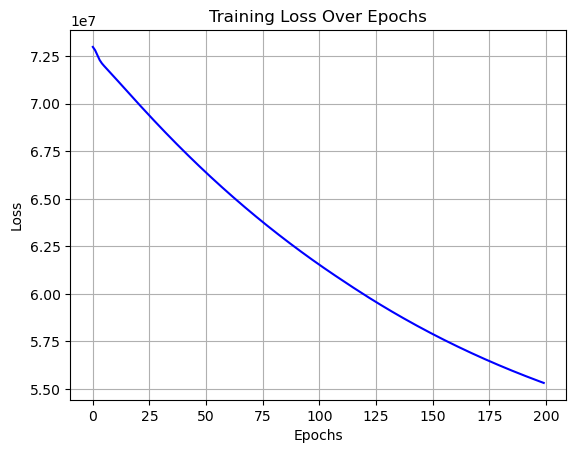

 10%|█         | 5/50 [00:01<00:10,  4.24it/s]

Epoch 5, Average Loss: 7811359.956015451


 20%|██        | 10/50 [00:02<00:08,  4.57it/s]

Epoch 10, Average Loss: 7729397.171070099


 30%|███       | 15/50 [00:03<00:07,  4.59it/s]

Epoch 15, Average Loss: 7622985.483646938


 40%|████      | 20/50 [00:04<00:06,  4.59it/s]

Epoch 20, Average Loss: 7514498.745001248


 50%|█████     | 25/50 [00:05<00:05,  4.64it/s]

Epoch 25, Average Loss: 7414925.9576328825


 60%|██████    | 30/50 [00:06<00:04,  4.62it/s]

Epoch 30, Average Loss: 7332082.36529541


 70%|███████   | 35/50 [00:07<00:03,  4.60it/s]

Epoch 35, Average Loss: 7310066.353593128


 80%|████████  | 40/50 [00:08<00:02,  4.60it/s]

Epoch 40, Average Loss: 7264157.03541129


 90%|█████████ | 45/50 [00:09<00:01,  4.61it/s]

Epoch 45, Average Loss: 7269669.562360491


100%|██████████| 50/50 [00:11<00:00,  4.51it/s]

Epoch 50, Average Loss: 7274762.859505789


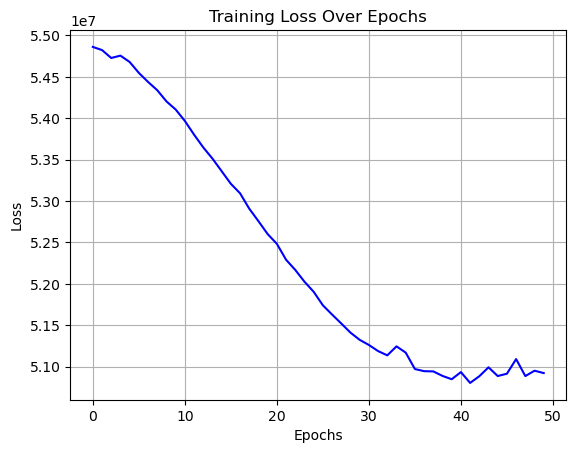

In [8]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-2)
train_whole_model(train_loader, lstm_model, optimizer, criterion, epochs=200)
train_each_model(train_loader, lstm_model, optimizer, criterion, epochs=50)

 10%|█         | 201/2000 [00:18<02:42, 11.05it/s]

Epoch 200, Average Loss: 6812211.0


 20%|██        | 401/2000 [00:36<02:26, 10.90it/s]

Epoch 400, Average Loss: 5200755.5


 30%|███       | 602/2000 [00:55<02:07, 10.93it/s]

Epoch 600, Average Loss: 4972266.5


 40%|████      | 802/2000 [01:13<01:54, 10.48it/s]

Epoch 800, Average Loss: 4712023.5


 50%|█████     | 1002/2000 [01:32<01:34, 10.56it/s]

Epoch 1000, Average Loss: 4493674.5


 60%|██████    | 1202/2000 [01:51<01:12, 11.03it/s]

Epoch 1200, Average Loss: 4291755.0


 70%|███████   | 1402/2000 [02:10<00:53, 11.20it/s]

Epoch 1400, Average Loss: 4104096.75


 80%|████████  | 1602/2000 [02:28<00:36, 11.05it/s]

Epoch 1600, Average Loss: 3933086.25


 90%|█████████ | 1802/2000 [02:47<00:18, 10.83it/s]

Epoch 1800, Average Loss: 3775224.25


100%|██████████| 2000/2000 [03:05<00:00, 10.80it/s]


Epoch 2000, Average Loss: 3624178.5


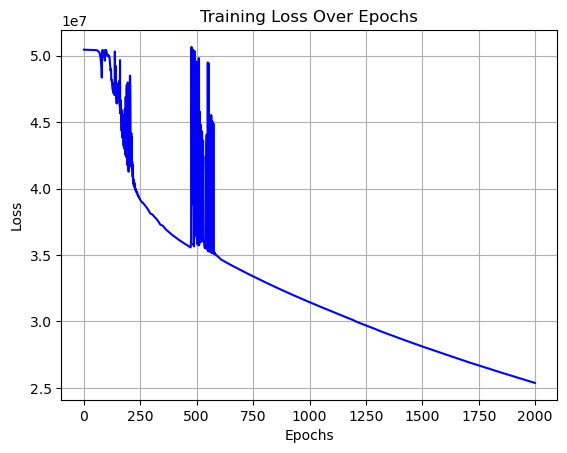

 10%|█         | 51/500 [00:10<01:32,  4.84it/s]

Epoch 50, Average Loss: 5829551.742826189


 20%|██        | 100/500 [00:21<01:22,  4.86it/s]

Epoch 100, Average Loss: 7199966.869315011


 30%|███       | 150/500 [00:33<01:36,  3.64it/s]

Epoch 150, Average Loss: 5599265.113725935


 40%|████      | 200/500 [00:45<01:05,  4.59it/s]

Epoch 200, Average Loss: 4930256.5291900635


 50%|█████     | 250/500 [00:56<00:51,  4.81it/s]

Epoch 250, Average Loss: 4383373.615549854


 60%|██████    | 300/500 [01:07<00:44,  4.50it/s]

Epoch 300, Average Loss: 7248225.54436384


 70%|███████   | 350/500 [01:19<00:35,  4.24it/s]

Epoch 350, Average Loss: 4014132.092049735


 80%|████████  | 400/500 [01:32<00:26,  3.72it/s]

Epoch 400, Average Loss: 2533056.876000098


 90%|█████████ | 450/500 [01:46<00:13,  3.68it/s]

Epoch 450, Average Loss: 3856096.8680513925


100%|██████████| 500/500 [01:59<00:00,  4.18it/s]

Epoch 500, Average Loss: 3721140.7934594834


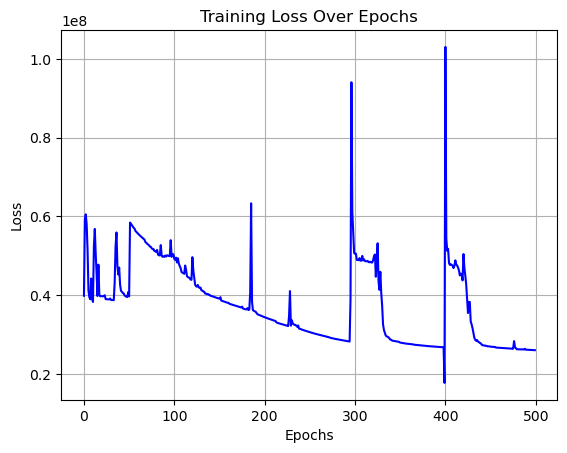

 10%|█         | 202/2000 [00:19<02:46, 10.77it/s]

Epoch 200, Average Loss: 1508419.375


 20%|██        | 402/2000 [00:38<02:34, 10.34it/s]

Epoch 400, Average Loss: 1327854.0


 30%|███       | 602/2000 [00:57<02:05, 11.14it/s]

Epoch 600, Average Loss: 1414913.0


 40%|████      | 802/2000 [01:15<01:48, 11.02it/s]

Epoch 800, Average Loss: 1447573.125


 50%|█████     | 1002/2000 [01:34<01:30, 11.00it/s]

Epoch 1000, Average Loss: 1165797.375


 60%|██████    | 1201/2000 [01:53<01:20,  9.97it/s]

Epoch 1200, Average Loss: 1377816.25


 70%|███████   | 1402/2000 [02:12<00:55, 10.78it/s]

Epoch 1400, Average Loss: 1385900.875


 80%|████████  | 1602/2000 [02:31<00:36, 10.91it/s]

Epoch 1600, Average Loss: 1361627.0


 90%|█████████ | 1802/2000 [02:49<00:17, 11.06it/s]

Epoch 1800, Average Loss: 1349654.75


100%|██████████| 2000/2000 [03:07<00:00, 10.66it/s]


Epoch 2000, Average Loss: 1185822.875


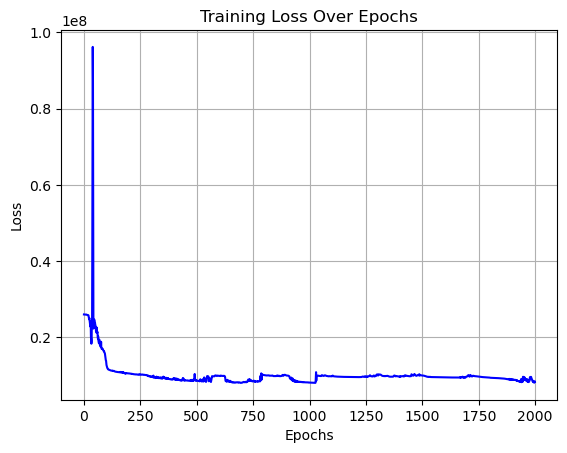

 10%|█         | 50/500 [00:10<01:37,  4.63it/s]

Epoch 50, Average Loss: 3774356.008078788


 20%|██        | 100/500 [00:23<01:47,  3.72it/s]

Epoch 100, Average Loss: 3619548.818257332


 30%|███       | 150/500 [00:38<01:33,  3.74it/s]

Epoch 150, Average Loss: 3765801.2324758256


 40%|████      | 200/500 [00:51<01:21,  3.70it/s]

Epoch 200, Average Loss: 3548375.202548027


 50%|█████     | 250/500 [01:06<01:06,  3.74it/s]

Epoch 250, Average Loss: 3423645.442784548


 60%|██████    | 300/500 [01:19<00:53,  3.71it/s]

Epoch 300, Average Loss: 3852254.7629082543


 70%|███████   | 350/500 [01:33<00:39,  3.77it/s]

Epoch 350, Average Loss: 3617145.517439161


 80%|████████  | 400/500 [01:45<00:20,  4.93it/s]

Epoch 400, Average Loss: 3460359.4868273055


 90%|█████████ | 450/500 [01:56<00:11,  4.33it/s]

Epoch 450, Average Loss: 3207235.4327665055


100%|██████████| 500/500 [02:07<00:00,  3.93it/s]

Epoch 500, Average Loss: 3324569.1843463355


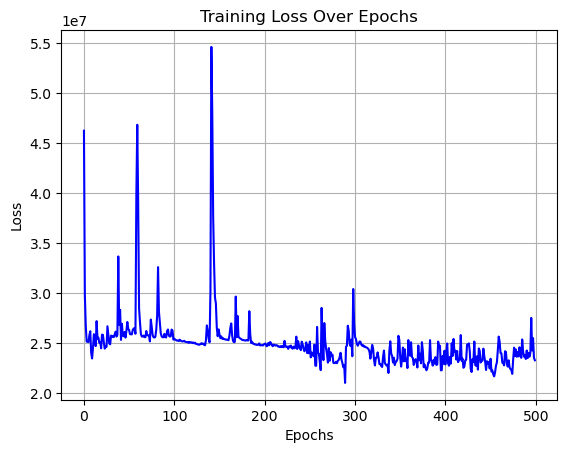

 10%|█         | 501/5000 [00:46<06:52, 10.91it/s]

Epoch 500, Average Loss: 602824.0


 20%|██        | 1001/5000 [01:33<06:05, 10.93it/s]

Epoch 1000, Average Loss: 546111.375


 30%|███       | 1501/5000 [02:20<05:20, 10.92it/s]

Epoch 1500, Average Loss: 483332.96875


 40%|████      | 2002/5000 [03:07<04:40, 10.68it/s]

Epoch 2000, Average Loss: 599986.1875


 50%|█████     | 2500/5000 [03:53<04:00, 10.39it/s]

Epoch 2500, Average Loss: 627238.4375


 60%|██████    | 3002/5000 [04:40<03:07, 10.64it/s]

Epoch 3000, Average Loss: 409888.40625


 70%|███████   | 3501/5000 [05:27<02:24, 10.37it/s]

Epoch 3500, Average Loss: 387845.0625


 80%|████████  | 4002/5000 [06:14<01:38, 10.12it/s]

Epoch 4000, Average Loss: 335378.03125


 90%|█████████ | 4502/5000 [07:01<00:47, 10.57it/s]

Epoch 4500, Average Loss: 381630.71875


100%|██████████| 5000/5000 [07:46<00:00, 10.71it/s]


Epoch 5000, Average Loss: 302276.5


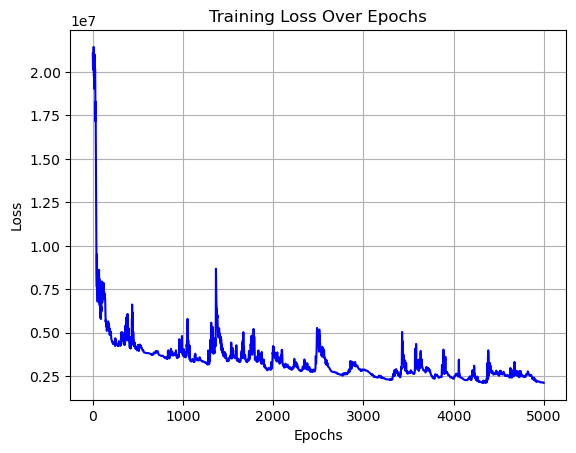

In [9]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)
for _ in range(2):
    train_whole_model(train_loader, lstm_model, optimizer, criterion, epochs=2000)
    train_each_model(train_loader, lstm_model, optimizer, criterion, epochs=500)

train_whole_model(train_loader, lstm_model, optimizer, criterion, epochs=5000)

In [10]:
import numpy as np
def binary_accuracy(predict, truth):
    diff1 = np.array(predict[1:])-np.array(predict[:-1])
    y_prediction = diff1 / np.abs(diff1)
    diff2 = np.array(truth[1:])-np.array(truth[:-1])
    truth_labels = diff2/ np.abs(diff2)

    negative = -1.0
    positive = 1.0

    tp = np.sum(np.logical_and(y_prediction == positive, truth_labels == positive))
    tn = np.sum(np.logical_and(y_prediction == negative, truth_labels == negative))
    fp = np.sum(np.logical_and(y_prediction == positive, truth_labels == negative))
    fn = np.sum(np.logical_and(y_prediction == negative, truth_labels == positive))
    s = tp+tn+fp+fn
    return tp/s, tn/s, fp/s, fn/s

true increase: 39%
true decrease: 33%
false increase: 17%
false decrease: 11%



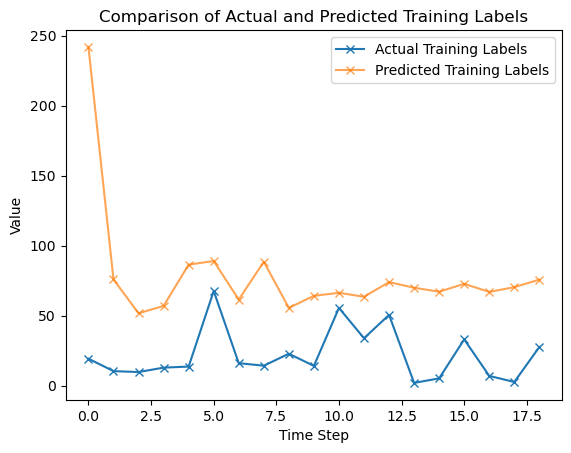

true increase: 28%
true decrease: 17%
false increase: 28%
false decrease: 28%



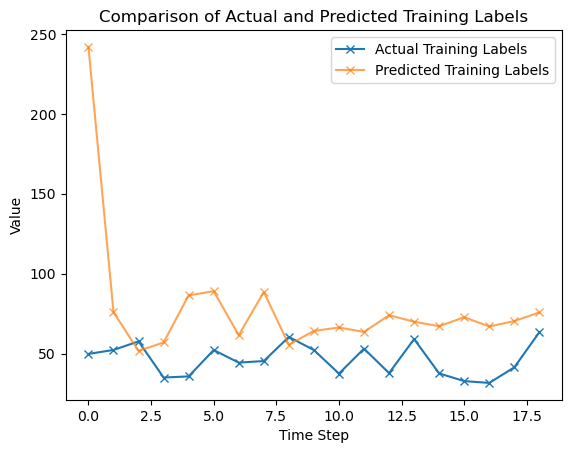

true increase: 33%
true decrease: 39%
false increase: 22%
false decrease: 6%



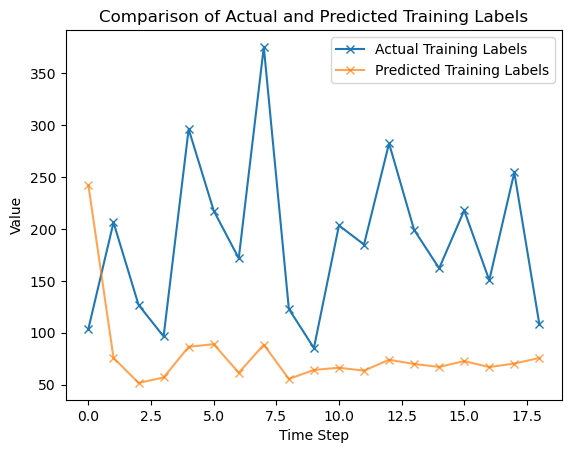

true increase: 39%
true decrease: 28%
false increase: 17%
false decrease: 17%



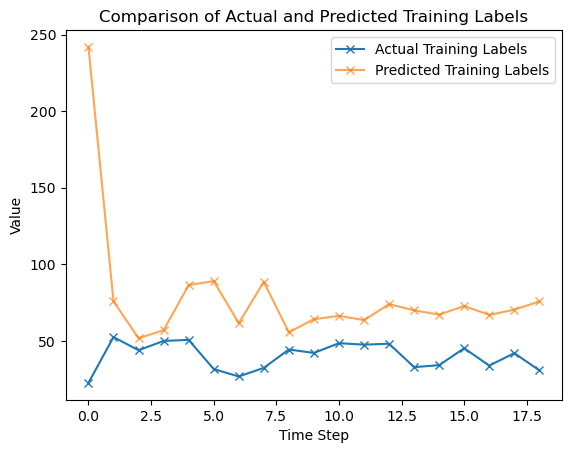

true increase: 39%
true decrease: 28%
false increase: 17%
false decrease: 17%



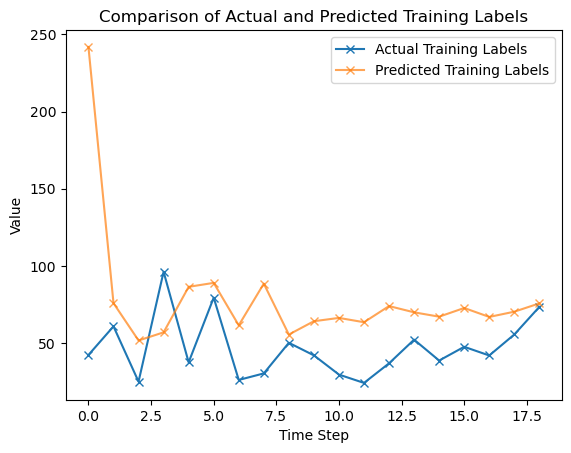

true increase: 50%
true decrease: 39%
false increase: 6%
false decrease: 6%



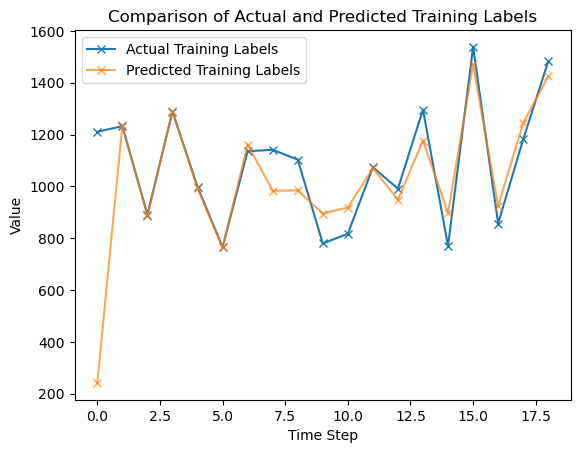

true increase: 44%
true decrease: 50%
false increase: 6%
false decrease: 0%



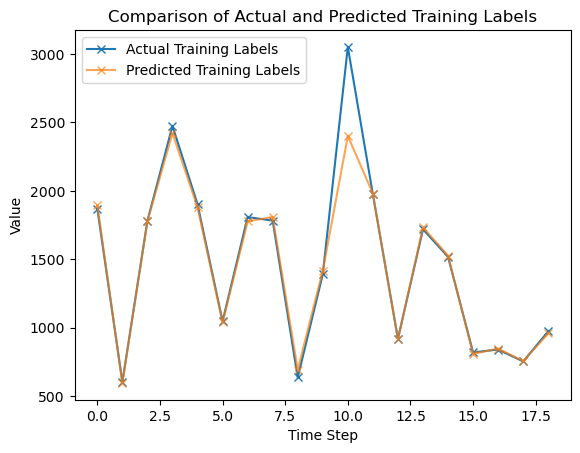

In [11]:
for data, labels in train_loader:
    train_predictions = generate_predictions(data.view(-1, input_size), lstm_model)
    # Convert train_labels to a list or a numpy array if it's a tensor
    train_labels_list = labels.squeeze().tolist()  # Adjust based on your actual format
    tp, tn, fp, fn = binary_accuracy(train_predictions, train_labels_list)
    print("true increase: {:.0%}\ntrue decrease: {:.0%}\nfalse increase: {:.0%}\nfalse decrease: {:.0%}\n".format(tp, tn, fp, fn))

    # Plot the actual and predicted values
    plt.plot(train_labels_list, marker='x', label='Actual Training Labels')
    plt.plot(train_predictions, marker='x', label='Predicted Training Labels', alpha=0.7)
    plt.title('Comparison of Actual and Predicted Training Labels')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

true increase: 39%
true decrease: 28%
false increase: 17%
false decrease: 17%



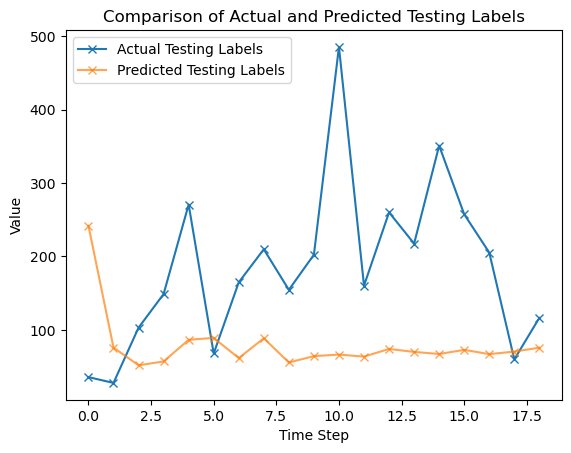

true increase: 22%
true decrease: 28%
false increase: 33%
false decrease: 17%



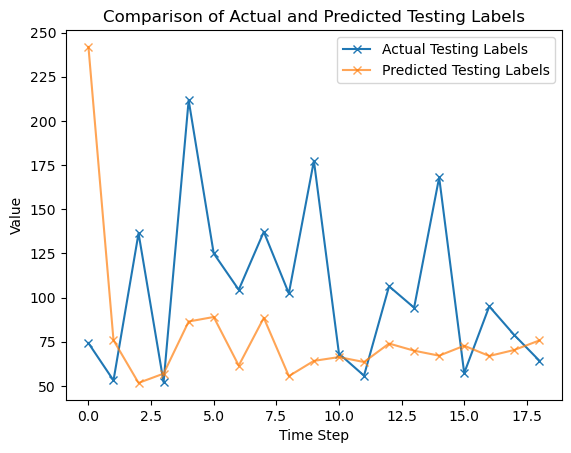

In [12]:
for data, labels in test_loader:
    test_predictions = generate_predictions(data.view(-1, 21), lstm_model)
    # Convert train_labels to a list or a numpy array if it's a tensor
    test_labels_list = labels.squeeze().tolist()  # Adjust based on your actual format
    tp, tn, fp, fn = binary_accuracy(test_predictions, test_labels_list)
    print("true increase: {:.0%}\ntrue decrease: {:.0%}\nfalse increase: {:.0%}\nfalse decrease: {:.0%}\n".format(tp, tn, fp, fn))

    # Plot the actual and predicted values
    plt.plot(test_labels_list, marker='x', label='Actual Testing Labels')
    plt.plot(test_predictions, marker='x', label='Predicted Testing Labels', alpha=0.7)
    plt.title('Comparison of Actual and Predicted Testing Labels')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

In [13]:
l=np.array([0.72, 0.45, 0.72, 0.67, 0.67, 0.89, 0.94])
l.mean()

0.722857142857143